In [1]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np


from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image

from matplotlib import pyplot as plt
%matplotlib inline
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x2, y2 = x1 + width, y1 + height

        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_images.append(face_array)

    return face_images

In [3]:
extracted_face=extract_face_from_image("C:/Users/PRATIK/Documents/Projects/Dataset/Test_Data/Img1001.jpg")

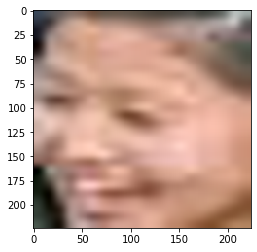

In [4]:
plt.imshow(extracted_face[0])
plt.show()

In [5]:
train_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Train_Data/"

In [6]:
resnet=tf.keras.applications.ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling="avg"
)
resnet.trainable=False
resnet2=tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3),pooling="avg")
resnet2.trainable=False

In [7]:
def create_model():
    #model1 = tf.keras.models.Sequential([
        #resnet,
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Reshape(target_shape=(64,32,1)),
        #resnet2,
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Dense(3, activation='softmax')
    #])
    x=resnet.output
    x=tf.keras.layers.Flatten()(x)
    #x=tf.keras.layers.Dense(256, activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    predictions=tf.keras.layers.Dense(3, activation='softmax')(x)
    model_1 = tf.keras.models.Model(inputs=resnet.input, outputs=predictions)
    x=resnet2.output
    x=tf.keras.layers.Flatten()(x)
    #x=tf.keras.layers.Dense(256, activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    predictions2=tf.keras.layers.Dense(3, activation='softmax')(x)
    model_2 = tf.keras.models.Model(inputs=resnet2.input, outputs=predictions2)
    merged = tf.keras.layers.concatenate([model_1.output, model_2.output])
    merged=tf.keras.layers.Flatten()(merged)
    merged=tf.keras.layers.Dropout(0.5)(merged)
    merged = tf.keras.layers.Dense(1024, activation='relu')(merged)
    num_classes=3
    merged = tf.keras.layers.Dense(num_classes, activation='softmax')(merged)
    model = tf.keras.models.Model([model_1.input, model_2.input], merged)
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=[tf.keras.metrics.Recall()])
    return model

model = create_model()
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 60,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   horizontal_flip = True)

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode="categorical",
                                                    batch_size = 8,
                                                    seed=42,
                                                    target_size = (224, 224),
                                                    shuffle=True) 

Found 5496 images belonging to 3 classes.


In [10]:
vaild_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Valid_Data/"

In [11]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [12]:
validation_generator = test_datagen.flow_from_directory(vaild_dir,
                                                    class_mode="categorical",
                                                    batch_size = 8,
                                                    seed=42,
                                                    target_size = (224, 224),
                                                    shuffle=True) 

Found 600 images belonging to 3 classes.


In [13]:
def generate_generator_multiple(generator,dir1):
    genX1 = generator.flow_from_directory(dir1,
                                          target_size = (224,224),
                                          class_mode = 'categorical',
                                          batch_size = 8,
                                          shuffle=True, 
                                          seed=42)
    
    genX2 = generator.flow_from_directory(dir1,
                                          target_size = (224,224),
                                          class_mode = 'categorical',
                                          batch_size = 8,
                                          shuffle=True, 
                                          seed=42)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label

In [14]:
train_generator=generate_generator_multiple(generator=train_datagen,dir1=train_dir)

In [15]:
validation_generator=generate_generator_multiple(generator=test_datagen,dir1=vaild_dir) 

In [16]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 5496//8,
            validation_steps = 600//8,
            epochs =10,
            verbose = 1)

Found 5496 images belonging to 3 classes.
Found 5496 images belonging to 3 classes.
Epoch 1/10
687/687 [==============================] - ETA: 0s - loss: 0.9346 - recall: 0.2401Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
687/687 [==============================] - 131s 191ms/step - loss: 0.9345 - recall: 0.2403 - val_loss: 0.6197 - val_recall: 0.7183
Epoch 2/10
687/687 [==============================] - 125s 182ms/step - loss: 0.7727 - recall: 0.5215 - val_loss: 0.6030 - val_recall: 0.7450
Epoch 3/10
687/687 [==============================] - 125s 182ms/step - loss: 0.7378 - recall: 0.5542 - val_loss: 0.6564 - val_recall: 0.7150
Epoch 4/10
181/687 [======>.......................] - ETA: 1:28 - loss: 0.7457 - recall: 0.5410

KeyboardInterrupt: 

In [ ]:
model.save("stage5.h5")

In [ ]:
model1= tf.keras.models.load_model("stage5.h5")

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv("Test.csv")

In [ ]:
df.head()

In [ ]:
filename=df["Filename"][102]
filename

In [ ]:
base_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Test_Data"

In [ ]:
sample_dir=base_dir+"/"+filename

In [ ]:
sample_dir

In [ ]:

def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
    image = plt.imread(image_path)
    detector = MTCNN()
    faces = detector.detect_faces(image)

    face_images = []
    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        print(face['box'])
        x2, y2 = x1 + width, y1 + height
        x1=max(0,x1)
        y1=max(0,y1)
        #x2=min(x2,image.shape[0])
        #y2=min(y2,image.shape[1])
        # extract the face
        face_boundary = image[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_array = face_array.astype('float32')
        # normalize to the range 0-1
        face_array /= 255.0

        face_array=face_array.reshape(1,224,224,3)
        face_images.append(face_array)

    return face_images
faces=extract_face_from_image(sample_dir)

In [ ]:
probs=[]

for face in faces:
    y_prob = model1.predict(face)
    probs.append(y_prob)
probsum=sum(probs)

label=np.argmax(probsum, axis=-1)
print(label)

In [ ]:
label_map = (train_generator.class_indices)
label_map

In [ ]:
base_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Test_Data"
index=0
d={'[0]':'Adults','[1]':'Teenagers','[2]':'Toddler'}
df["Category"]=""
for file in df["Filename"]:
    sample_dir=base_dir+"/"+file
    faces=extract_face_from_image(sample_dir)
    
    probs=[]
    for face in faces:
        y_prob = model1.predict(face)
        probs.append(y_prob)
    probsum=sum(probs)
    label=np.argmax(probsum, axis=-1)
    
    print(index)
    label=str(label)
    print(label)
    if label not in ['[0]','[1]','[2]']:
        label='[2]'
    pred=d[str(label)]
    df["Category"][index]=pred
    print(pred)
    index+=1
df.head()
    
    
    

In [ ]:
df.to_csv("submission2.csv",index=False)

In [ ]:
model1= tf.keras.models.load_model("pratik.h5")

In [ ]:
base_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Test_Data"
index=0
d={0:'Adults',1:'Teenagers',2:'Toddler'}
df["Category"]=""
for file in df["Filename"]:
    sample_dir=base_dir+"/"+file
    faces=extract_face_from_image(sample_dir)
    
    probs=[]
    for face in faces:
        y_prob = model1.predict(face)
        label=np.argmax(y_prob, axis=-1)
        label=str(label)
        probs.append(int(label[1]))
    
    
    
    print(index)
    if len(probs)>0:
        label=max(probs)
    else:
        label=2
    print(label)
    pred=d[label]
    df["Category"][index]=pred
    print(pred)
    index+=1
df.head()

In [ ]:
df.to_csv("Submission4.csv",index=False)

In [ ]:
model1= tf.keras.models.load_model("pratik.h5")

In [ ]:
base_dir="C:/Users/PRATIK/Documents/Projects/Dataset/Test_Data"
index=0
d={0:'Adults',1:'Teenagers',2:'Toddler'}
df["Category"]=""
for file in df["Filename"]:
    sample_dir=base_dir+"/"+file
    faces=extract_face_from_image(sample_dir)
    
    probs=[]
    for face in faces:
        y_prob = model1.predict(face)
        label=np.argmax(y_prob, axis=-1)
        label=str(label)
        probs.append(int(label[1]))
    
    
    
    print(index)
    n=len(probs)
    if n>0:
        label=np.mean(probs)
        label=np.round(label,0)
        label=int(label)
    else:
        label=2
    print(label)
    pred=d[label]
    df["Category"][index]=pred
    print(pred)
    index+=1
df.head()

In [ ]:
df.to_csv("Submission5.csv",index=False)